# HPGe Simulation: 58-P13874A

Importing libraries and initialising global constants

In [1]:
import openmc
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.signal import peak_widths
import os
import openmc_tools

In [2]:
#taken from europium gamma decay spectrum, all decay channels with an intensity >0.01%
eu152_energy_peaks_ev = np.array([121781.7, 125690, 148010, 212568, 244697.4, 251633, 271131, 275449, 285980, 295938.7, 315174, 324830, 329425, 340400,
                           344278.5, 351660, 367789.1, 411116.5, 416048, 440860, 443965, 482310, 488679.2, 493508, 503474, 511000, 520227, 523130,
                           526881, 534245, 556560, 562930, 563990, 566442, 586265, 656489, 664780, 671155, 674675, 674677, 678623, 686610, 688670,
                           712843, 719349, 727990, 764900, 768944, 778904.5, 794810, 810451, 839360, 841574, 867380, 896580, 901181, 906010, 919337,
                           926317, 930580, 958630, 963390, 964079, 974090, 990190, 1005272, 1084000, 1085337, 1089737, 1109174, 1112076, 1170930,
                           1206110, 1212948, 1249938, 1261343, 1292778, 1299142, 1348100, 1363770, 1408013, 1457643, 1528103])

eu152_decay_intensities = np.array([28.41, 0.019, 0.035, 0.0196, 7.55, 0.0671, 0.078, 0.0323, 0.01, 0.442, 0.0496, 0.0738, 0.129, 0.031, 26.59,
                                        0.014, 0.862, 2.238, 0.109, 0.0133, 0.32, 2.8, 0.0279, 0.4139, 0.0278, 0.1533, 0.054, 0.0536, 0.0113, 0.0129, 
                                        0.0368, 0.0177, 0.038, 0.457, 0.131, 0.462,  0.1437, 0.01, 0.0194, 0.17, 0.0171, 0.47, 0.02, 0.841, 0.0961,
                                        0.268, 0.0106, 0.19, 0.088, 12.97, 0.0263, 0.317, 0.016, 4.243, 0.0669, 0.084, 0.016, 0.429, 0.273, 0.0729,
                                        0.021, 0.1341, 14.5, 0.0138, 0.0315, 0.665, 0.244, 10.13, 1.73, 0.186, 13.41, 0.0365, 0.0135, 1.416, 0.186,
                                        0.0336, 0.104, 1.633, 0.0175, 0.0256, 20.85, 0.498, 0.281])


co60_energy_peaks_ev = np.array([347140, 826100, 1173222.8, 1332492, 2158570, 2505692])
co60_decay_intensities = np.array([0.0075, 0.0076, 99.85, 99.9826, 0.0012, 0.000002])

am241_energy_peaks_ev = np.array([26344.6, 33.196, 43420, 55560, 59540.9, 98970, 102980])
am241_decay_intensities = np.array([2.27, 0.126, 0.073, 0.0181, 35.9, 0.0203,  0.0195])

cs137_energy_peaks_ev = np.array([283500, 661657])
cs137_decay_intensities = np.array([0.00058, 85.1])

na22_energy_peaks_ev = np.array([1274537])
na22_decay_intensities = np.array([99.940])

mn54_energy_peaks_ev = np.array([834848])
mn54_decay_intensities = np.array([99.9760])

ba133_energy_peaks_ev = np.array([53162.2, 79614.2, 80997.9, 160612.0, 223236.8, 276398.9, 302850.8, 356012.9, 383848.5])
ba133_decay_intensities = np.array([2.14, 2.65, 32.9, 0.638, 0.453, 7.16, 18.34, 62.05, 8.94])

co57_energy_peaks_ev = np.array([14412.9, 122060.5, 136473.56, 230400, 339690, 352330, 366800, 570090, 692410, 706540])
co57_decay_intensities = np.array([9.16, 85.6, 10.68, 0.0004, 0.0037, 0.003, 0.0012, 0.0158, 0.149, 0.005])

eu152_decay_probabilities = openmc_tools.find_decay_probabilities(eu152_decay_intensities)
co60_decay_probabilities = openmc_tools.find_decay_probabilities(co60_decay_intensities)
am241_decay_probabilities = openmc_tools.find_decay_probabilities(am241_decay_intensities)
cs137_decay_probabilities = openmc_tools.find_decay_probabilities(cs137_decay_intensities)
na22_decay_probabilities = openmc_tools.find_decay_probabilities(na22_decay_intensities)
mn54_decay_probabilities = openmc_tools.find_decay_probabilities(mn54_decay_intensities)
ba133_decay_probabilities = openmc_tools.find_decay_probabilities(ba133_decay_intensities)
co57_decay_probabilities = openmc_tools.find_decay_probabilities(co57_decay_intensities)

In [3]:
time_since_calibration = 1014 * 86400 #seconds, accurate to nearest day

co60_initial_activity = 43000 #kBq
am241_initial_activity = 41400 #kBq
cs137_initial_activity = 40200 #kBq
na22_initial_activity = 39100 #kBq
mn54_initial_activity = 42500 #kBq
ba133_initial_activity = 43200 #kBq
co57_initial_activity = 42600 #kBq

co60_half_life = 5.271 * 365 * 24 * 60 * 60
am241_half_life = 432.6 * 365 * 24 * 60 * 60 #s, half life taken from nndc
cs137_half_life = 30.007 * 365 * 24 * 60 * 60
na22_half_life = 2.60 * 365 * 24 * 60 * 60
mn54_half_life = 312.1 * 24 * 60 * 60
ba133_half_life = 10.536 * 365 * 24 * 60 * 60
co57_half_life = 271.8 * 24 * 60 * 60

co60_activity = openmc_tools.find_current_activity(co60_initial_activity, time_since_calibration, co60_half_life)
am241_activity = openmc_tools.find_current_activity(am241_initial_activity, time_since_calibration, am241_half_life)
cs137_activity = openmc_tools.find_current_activity(cs137_initial_activity, time_since_calibration, cs137_half_life)
na22_activity = openmc_tools.find_current_activity(na22_initial_activity, time_since_calibration, na22_half_life)
mn54_activity = openmc_tools.find_current_activity(mn54_initial_activity, time_since_calibration, mn54_half_life)
ba133_activity = openmc_tools.find_current_activity(ba133_initial_activity, time_since_calibration, ba133_half_life)
co57_activity = openmc_tools.find_current_activity(co57_initial_activity, time_since_calibration, co57_half_life)

## Defining the materials

In [4]:
#materials
aluminium_mat = openmc.Material()
aluminium_mat.add_element('Al', 1, percent_type = 'ao')
aluminium_mat.set_density('g/cm3', 2.6989)

boron_mat = openmc.Material()
boron_mat.add_element('B', 1, percent_type = 'ao')
boron_mat.set_density('g/cm3', 2.37)

copper_mat = openmc.Material()
copper_mat.add_element('Cu', 1, percent_type = 'ao')
copper_mat.set_density('g/cm3', 8.96)

germanium_mat = openmc.Material()
germanium_mat.add_element('Ge', 1, percent_type = 'ao')
germanium_mat.set_density('g/cm3', 5.323)

lead_mat = openmc.Material()
lead_mat.add_element('Pb', 1, percent_type = 'ao')
lead_mat.set_density('g/cm3', 11.35)

lithium_mat = openmc.Material()
lithium_mat.add_element('Li', 1, percent_type = 'ao')
lithium_mat.set_density('g/cm3', 0.534)

mylar_mat = openmc.Material()
mylar_mat.add_element('C', 10, percent_type = 'ao')
mylar_mat.add_element('H', 8, percent_type = 'ao')
mylar_mat.add_element('O', 4, percent_type = 'ao')
mylar_mat.set_density('g/cm3', 1.38)

vacuum_mat = openmc.Material()#setting a vacuum material as air with a near-zero density
vacuum_mat.add_element('C', 0.00015, percent_type = 'ao')
vacuum_mat.add_element('N', 0.784429, percent_type = 'ao')
vacuum_mat.add_element('O', 0.210750, percent_type = 'ao')
vacuum_mat.add_element('Ar', 0.004671, percent_type = 'ao')
vacuum_mat.set_density('g/cm3', 0.001)


materials = openmc.Materials([aluminium_mat, boron_mat, copper_mat, germanium_mat, lead_mat, lithium_mat, mylar_mat, vacuum_mat])
materials.export_to_xml()

## Defining the geometries

In [5]:
#surfaces

lead_shield_out = openmc.model.RightCircularCylinder([0, 0, -28], 61, 28.5, axis = 'z', boundary_type = 'vacuum')
lead_shield_in = openmc.model.RightCircularCylinder([0, 0, -23], 46, 12.5, axis = 'z', boundary_type = 'vacuum')

outer_cylinder_out = openmc.model.RightCircularCylinder([0, 0, -23], 22.9, 5, axis = 'z')
outer_cylinder_in = openmc.model.RightCircularCylinder([0, 0, -23], 22.9, 4.9, axis = 'z')

aluminium_case_out = openmc.model.RightCircularCylinder([0, 0, -11.006], 10.5, 4.5, axis = 'z')
aluminium_case_in = openmc.model.RightCircularCylinder([0, 0, -10.706], 10.2, 4.42, axis = 'z')

aluminium_layer = openmc.model.RightCircularCylinder([0, 0, -0.506], 0.003, 4.5, axis = 'z')
mylar_layer = openmc.model.RightCircularCylinder([0, 0, -0.503], 0.003, 4.5, axis = 'z')

outer_dead_layer = openmc.model.RightCircularCylinder([0, 0, -5.536], 5.03, 3.50003, axis = 'z')

germanium_crystal = openmc.model.RightCircularCylinder([0, 0, -5.536], 5.03, 3.5, axis = 'z')
germanium_crystal.id = 1

interior_hole_cylinder = openmc.model.RightCircularCylinder((0, 0, -23), 20.644, 0.44, axis = 'z')
interior_hole_sphere = openmc.Sphere(0, 0, -2.356, 0.44)

inner_dead_layer_cylinder = openmc.model.RightCircularCylinder([0, 0, -5.536], 3.18, 0.447, axis = 'z')
inner_dead_layer_sphere = openmc.Sphere(0, 0, -2.356, 0.447)

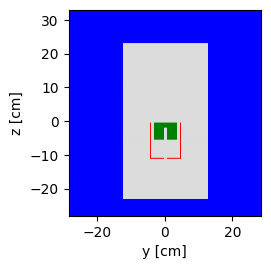

In [6]:
colour_assignment = {aluminium_mat: 'red', boron_mat: 'orange', copper_mat: 'cyan', lead_mat: 'blue', lithium_mat: 'yellow',
                     germanium_mat: 'green', mylar_mat: 'purple', vacuum_mat: 'gainsboro'}
material_labels = {aluminium_mat: "Aluminium", boron_mat: "Boron", copper_mat: "Copper", lithium_mat: "Lithium",
                   lead_mat: "Lead", germanium_mat: "Germanium", mylar_mat: "Mylar", vacuum_mat: "Vacuum"}

rounded_hole_region = -interior_hole_cylinder | -interior_hole_sphere
dead_layer_region = -inner_dead_layer_cylinder | -inner_dead_layer_sphere

lead_shield_region = -lead_shield_out & +lead_shield_in
lead_shield_cell = openmc.Cell(region = lead_shield_region)
lead_shield_cell.fill = lead_mat

outer_cylinder_region = -outer_cylinder_out & +outer_cylinder_in & ~rounded_hole_region
outer_cylinder_cell = openmc.Cell(region = outer_cylinder_region)
outer_cylinder_cell.fill = aluminium_mat

aluminium_case_region = -aluminium_case_out & +aluminium_case_in & ~rounded_hole_region
aluminium_case_cell = openmc.Cell(region = aluminium_case_region)
aluminium_case_cell.fill = aluminium_mat

aluminium_layer_region = -aluminium_layer
aluminium_layer_cell = openmc.Cell(region = aluminium_layer_region)
aluminium_layer_cell.fill = aluminium_mat

mylar_layer_region = -mylar_layer
mylar_layer_cell = openmc.Cell(region = mylar_layer_region)
mylar_layer_cell.fill = mylar_mat

germanium_crystal_region = -germanium_crystal & ~rounded_hole_region & ~dead_layer_region
germanium_crystal_cell = openmc.Cell(region = germanium_crystal_region)
germanium_crystal_cell.fill = germanium_mat

inner_dead_layer_region = dead_layer_region & -germanium_crystal & ~rounded_hole_region
inner_dead_layer_cell = openmc.Cell(region = inner_dead_layer_region)
inner_dead_layer_cell.fill = boron_mat

outer_dead_layer_region = -outer_dead_layer & ~germanium_crystal_region & ~inner_dead_layer_region & ~rounded_hole_region
outer_dead_layer_cell = openmc.Cell(region = outer_dead_layer_region)
outer_dead_layer_cell.fill = lithium_mat

vacuum_region = -lead_shield_in & ~outer_cylinder_region & ~aluminium_case_region & ~aluminium_layer_region & ~mylar_layer_region & ~germanium_crystal_region & ~outer_dead_layer_region & ~inner_dead_layer_region
vacuum_cell = openmc.Cell(region=vacuum_region)
vacuum_cell.fill = vacuum_mat

geometry = openmc.Geometry([lead_shield_cell, outer_cylinder_cell, aluminium_case_cell, germanium_crystal_cell, aluminium_layer_cell, 
                            mylar_layer_cell, vacuum_cell, outer_dead_layer_cell, inner_dead_layer_cell])

plot = geometry.plot(basis = 'yz', color_by = 'material', colors = colour_assignment)

geometry.export_to_xml()


## Creating settings

In [7]:
num_particles = 1000000
num_batches = 100
source_loc = (0, 0, 0.5)
    
eu152_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, eu152_energy_peaks_ev, eu152_decay_probabilities)
co60_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, co60_energy_peaks_ev, co60_decay_probabilities)
am241_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, am241_energy_peaks_ev, am241_decay_probabilities)
cs137_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, cs137_energy_peaks_ev, cs137_decay_probabilities)
na22_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, na22_energy_peaks_ev, na22_decay_probabilities)
mn54_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, mn54_energy_peaks_ev, mn54_decay_probabilities)
ba133_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, ba133_energy_peaks_ev, ba133_decay_probabilities)
co57_settings = openmc_tools.create_hpge_settings(num_particles, num_batches, source_loc, co57_energy_peaks_ev, co57_decay_probabilities)

energy_bins = np.linspace(co57_energy_peaks_ev[0]-10000, co60_energy_peaks_ev[-1]+10000, num = 8192)
tallies = openmc_tools.create_hpge_spectrum_tally(germanium_crystal_cell, energy_bins)

## Running initial HPGe spectra simulation

In [8]:
%%time

eu152_results = openmc_tools.openmc_sim(geometry, materials, eu152_settings, tallies)
eu152_spectrum = eu152_results["pulse_height"]

co60_results = openmc_tools.openmc_sim(geometry, materials, co60_settings, tallies)
co60_spectrum = co60_results["pulse_height"]

am241_results = openmc_tools.openmc_sim(geometry, materials, am241_settings, tallies)
am241_spectrum = am241_results["pulse_height"]

cs137_results = openmc_tools.openmc_sim(geometry, materials, cs137_settings, tallies)
cs137_spectrum = cs137_results["pulse_height"]

na22_results = openmc_tools.openmc_sim(geometry, materials, na22_settings, tallies)
na22_spectrum = na22_results["pulse_height"]

mn54_results = openmc_tools.openmc_sim(geometry, materials, mn54_settings, tallies)
mn54_spectrum = mn54_results["pulse_height"]

ba133_results = openmc_tools.openmc_sim(geometry, materials, ba133_settings, tallies)
ba133_spectrum = ba133_results["pulse_height"]

co57_results = openmc_tools.openmc_sim(geometry, materials, co57_settings, tallies)
co57_spectrum = co57_results["pulse_height"]

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

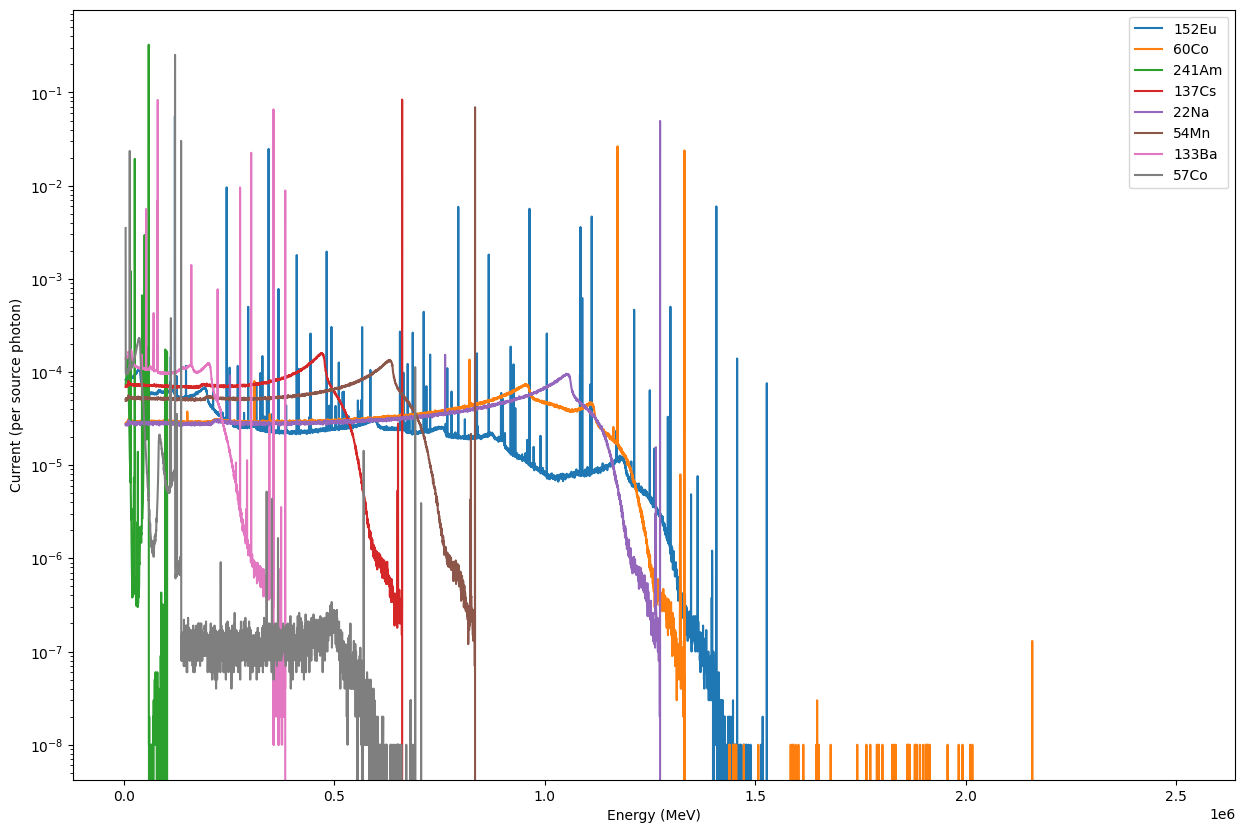

In [9]:
plt.figure(figsize = [15, 10])
results_array = [eu152_spectrum, co60_spectrum, am241_spectrum, cs137_spectrum, na22_spectrum, mn54_spectrum,
                 ba133_spectrum, co57_spectrum]
labels = ["152Eu", "60Co", "241Am", "137Cs", "22Na", "54Mn", "133Ba", "57Co"]

for i in range(len(results_array)):
    plt.plot(energy_bins[:-1], results_array[i], label = labels[i])
    
plt.yscale('log')
#plt.xlim(right = 1.5E6)
plt.xlabel('Energy (MeV)')
plt.ylabel('Current (per source photon)')
plt.legend()
plt.show()

## Removing the background spectrum

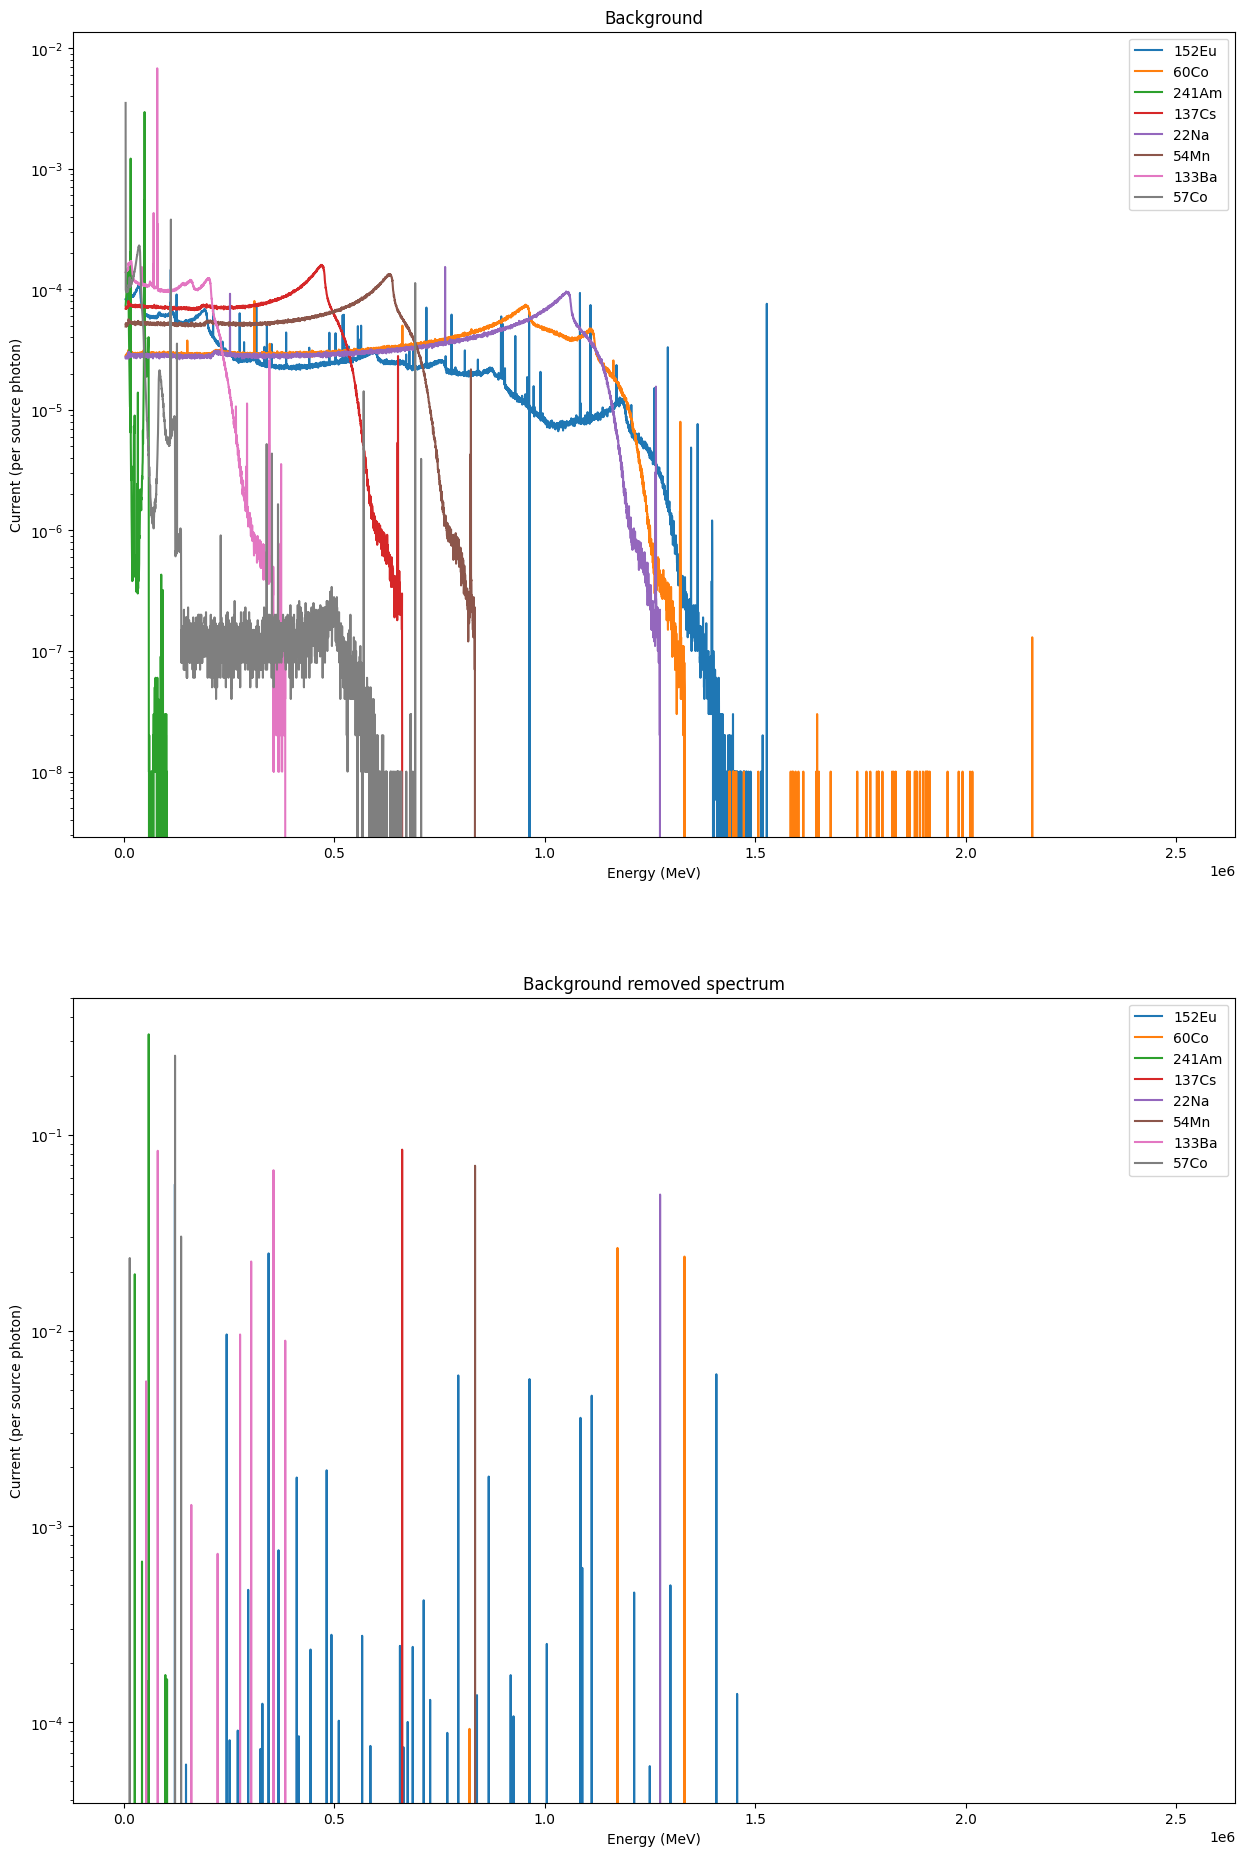

In [10]:
fig, ax = plt.subplots(2,1)
fig.set_figheight(23)
fig.set_figwidth(15)

eu152_background = openmc_tools.find_background_spectrum(energy_bins[:-1], eu152_spectrum, eu152_energy_peaks_ev)
co60_background = openmc_tools.find_background_spectrum(energy_bins[:-1], co60_spectrum, co60_energy_peaks_ev)
am241_background = openmc_tools.find_background_spectrum(energy_bins[:-1], am241_spectrum, am241_energy_peaks_ev)
cs137_background = openmc_tools.find_background_spectrum(energy_bins[:-1], cs137_spectrum, cs137_energy_peaks_ev)
na22_background = openmc_tools.find_background_spectrum(energy_bins[:-1], na22_spectrum, na22_energy_peaks_ev)
mn54_background = openmc_tools.find_background_spectrum(energy_bins[:-1], mn54_spectrum, mn54_energy_peaks_ev)
ba133_background = openmc_tools.find_background_spectrum(energy_bins[:-1], ba133_spectrum, ba133_energy_peaks_ev)
co57_background = openmc_tools.find_background_spectrum(energy_bins[:-1], co57_spectrum, co57_energy_peaks_ev)
backgrounds_array = [eu152_background, co60_background, am241_background, cs137_background, na22_background, mn54_background, ba133_background,
                     co57_background]

eu152_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(eu152_spectrum, eu152_background)
co60_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(co60_spectrum, co60_background)
am241_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(am241_spectrum, am241_background)
cs137_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(cs137_spectrum, cs137_background)
na22_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(na22_spectrum, na22_background)
mn54_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(mn54_spectrum, mn54_background)
ba133_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(ba133_spectrum, ba133_background)
co57_background_removed_spectrum = openmc_tools.get_background_removed_spectrum(co57_spectrum, co57_background)
background_removed_spectra_array = [eu152_background_removed_spectrum, co60_background_removed_spectrum, am241_background_removed_spectrum,
                                   cs137_background_removed_spectrum, na22_background_removed_spectrum, mn54_background_removed_spectrum,
                                    ba133_background_removed_spectrum, co57_background_removed_spectrum]

for i in range(len(labels)):
    ax[0].plot(energy_bins[:-1], backgrounds_array[i], label = labels[i])
    ax[1].plot(energy_bins[:-1], background_removed_spectra_array[i], label = labels[i])

    
ax[0].set_yscale('log')
ax[0].set_xlabel('Energy (MeV)')
ax[0].set_ylabel('Current (per source photon)')
ax[0].set_title('Background')
ax[0].legend()

ax[1].set_yscale('log')
ax[1].set_xlabel('Energy (MeV)')
ax[1].set_ylabel('Current (per source photon)')
ax[1].set_title('Background removed spectrum')
ax[1].legend()

plt.show()

## Finding the peaks in the data

40
3
6
1
1
1
8
3


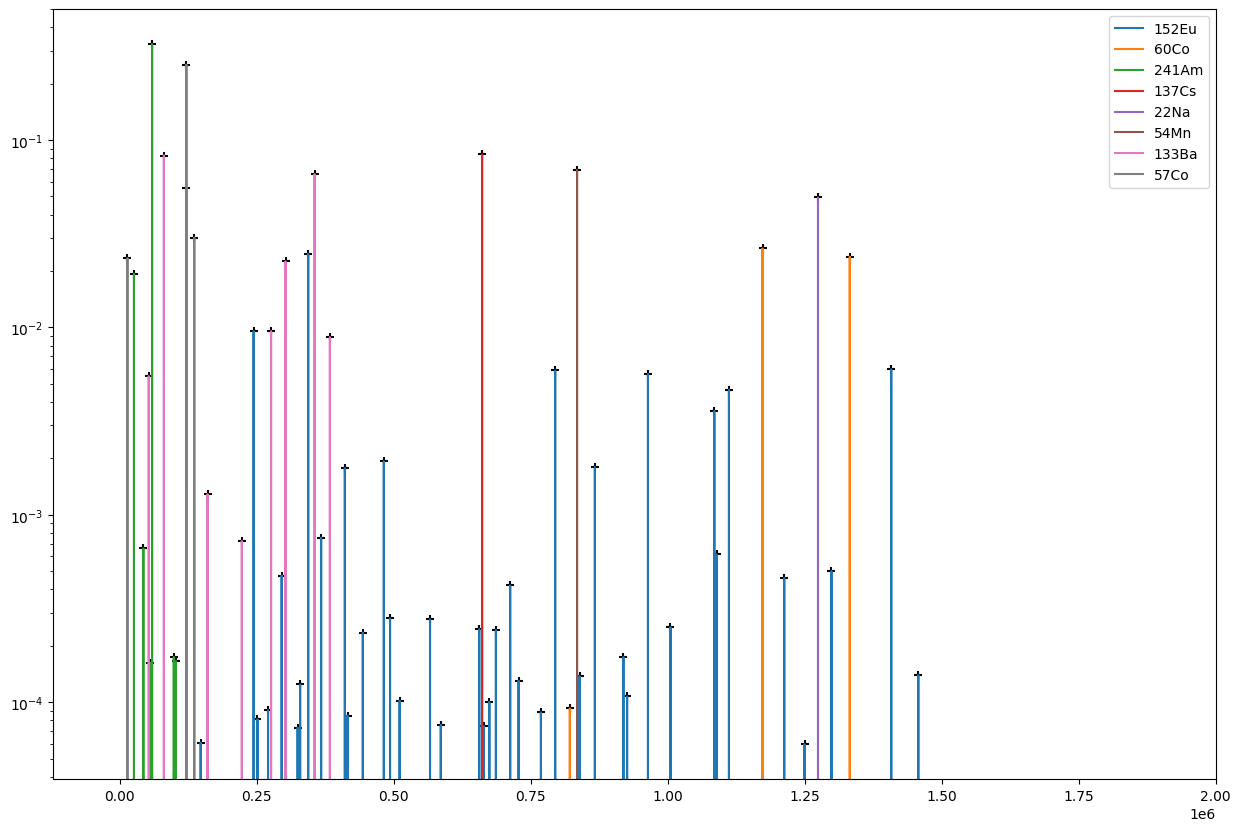

In [11]:
fig = plt.figure(figsize=[15, 10])

eu152_peaks_location, eu152_peaks = openmc_tools.find_peaks(energy_bins[:-1], eu152_background_removed_spectrum, eu152_energy_peaks_ev)
co60_peaks_location, co60_peaks = openmc_tools.find_peaks(energy_bins[:-1], co60_background_removed_spectrum, co60_energy_peaks_ev)
am241_peaks_location, am241_peaks = openmc_tools.find_peaks(energy_bins[:-1], am241_background_removed_spectrum, am241_energy_peaks_ev)
cs137_peaks_location, cs137_peaks = openmc_tools.find_peaks(energy_bins[:-1], cs137_background_removed_spectrum, cs137_energy_peaks_ev)
na22_peaks_location, na22_peaks = openmc_tools.find_peaks(energy_bins[:-1], na22_background_removed_spectrum, na22_energy_peaks_ev)
mn54_peaks_location, mn54_peaks = openmc_tools.find_peaks(energy_bins[:-1], mn54_background_removed_spectrum, mn54_energy_peaks_ev)
ba133_peaks_location, ba133_peaks = openmc_tools.find_peaks(energy_bins[:-1], ba133_background_removed_spectrum, ba133_energy_peaks_ev)
co57_peaks_location, co57_peaks = openmc_tools.find_peaks(energy_bins[:-1], co57_background_removed_spectrum, co57_energy_peaks_ev)

peak_locations_array = [eu152_peaks_location, co60_peaks_location, am241_peaks_location, cs137_peaks_location, na22_peaks_location, mn54_peaks_location,
                       ba133_peaks_location, co57_peaks_location]
peaks_array = [eu152_peaks, co60_peaks, am241_peaks, cs137_peaks, na22_peaks, mn54_peaks, ba133_peaks, co57_peaks]#contains duplicate values

for i in range(len(labels)):
    plt.plot(energy_bins[:-1], background_removed_spectra_array[i], label = labels[i])
    plt.scatter(peak_locations_array[i], peaks_array[i], marker = '+', color = 'k')
    print(len(peaks_array[i]))

plt.yscale('log')
plt.xlim(right = 2E6)
plt.legend()
plt.show()

## Finding absolute efficiency

calculating absolute efficiency by finding the ratio of the peak heights to the number of photons emitted at the peak energy

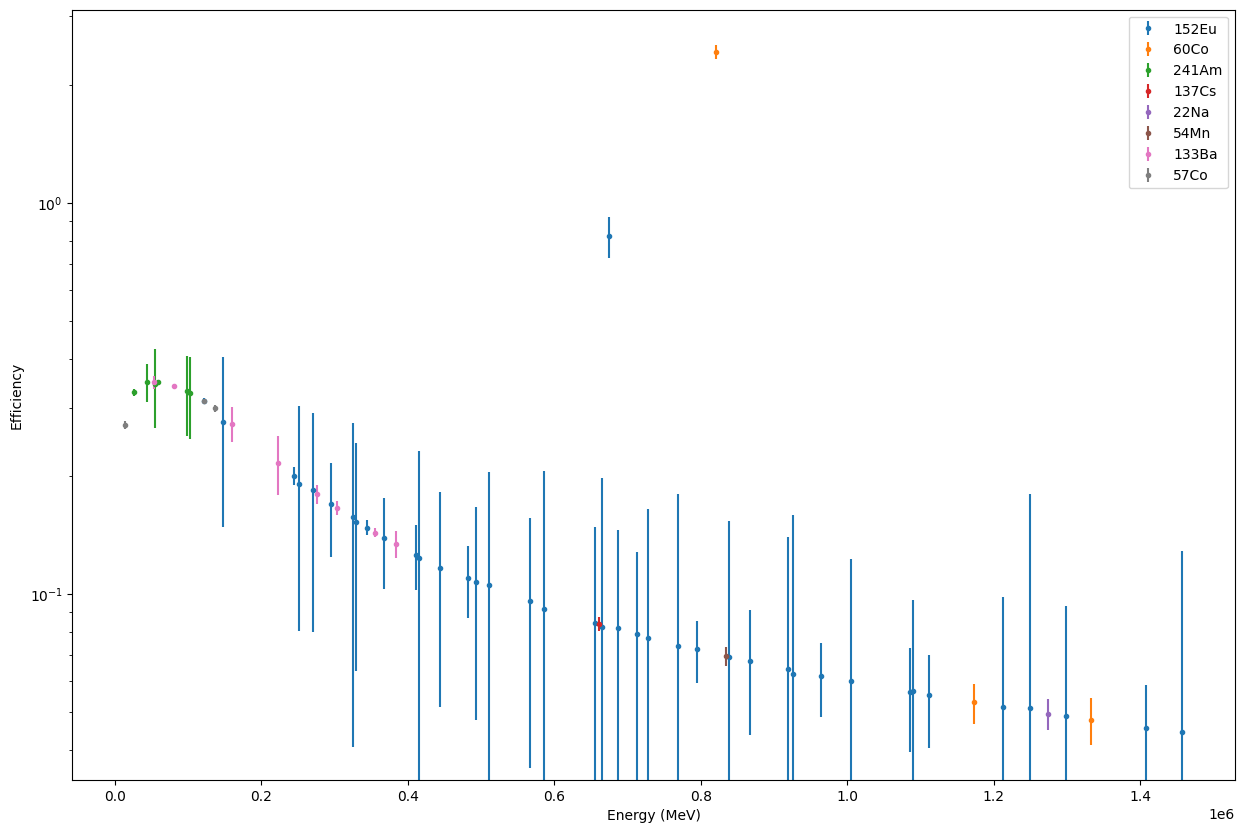

In [12]:
fig = plt.figure(figsize = [15,10])

eu152_efficiency, eu152_error = openmc_tools.find_absolute_efficiency(eu152_peaks_location, eu152_peaks, eu152_energy_peaks_ev, eu152_decay_probabilities, num_particles)
co60_efficiency, co60_error = openmc_tools.find_absolute_efficiency(co60_peaks_location, co60_peaks, co60_energy_peaks_ev, co60_decay_probabilities, num_particles)
am241_efficiency, am241_error = openmc_tools.find_absolute_efficiency(am241_peaks_location, am241_peaks, am241_energy_peaks_ev, am241_decay_probabilities, num_particles)
cs137_efficiency, cs137_error = openmc_tools.find_absolute_efficiency(cs137_peaks_location, cs137_peaks, cs137_energy_peaks_ev, cs137_decay_probabilities, num_particles)
na22_efficiency, na22_error = openmc_tools.find_absolute_efficiency(na22_peaks_location, na22_peaks, na22_energy_peaks_ev, na22_decay_probabilities, num_particles)
mn54_efficiency, mn54_error = openmc_tools.find_absolute_efficiency(mn54_peaks_location, mn54_peaks, mn54_energy_peaks_ev, mn54_decay_probabilities, num_particles)
ba133_efficiency, ba133_error = openmc_tools.find_absolute_efficiency(ba133_peaks_location, ba133_peaks, ba133_energy_peaks_ev, ba133_decay_probabilities, num_particles)
co57_efficiency, co57_error = openmc_tools.find_absolute_efficiency(co57_peaks_location, co57_peaks, co57_energy_peaks_ev, co57_decay_probabilities, num_particles)

efficiencies_array = [eu152_efficiency, co60_efficiency, am241_efficiency, cs137_efficiency, na22_efficiency, mn54_efficiency, ba133_efficiency, 
                      co57_efficiency]
errors = [eu152_error, co60_error, am241_error, cs137_error, na22_error, mn54_error, ba133_error, co57_error]


for i in range(len(labels)):
    plt.errorbar(peak_locations_array[i], efficiencies_array[i], yerr = errors[i], fmt = '.', label = labels[i])

plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

## Improving high uncertainty efficiency values

In [13]:
#running another simulation to fix areas with high error
eu152_high_energy_peak_1 = np.array([1528103])
eu152_high_energy_probability_1 = np.array([eu152_decay_probabilities[-1]])
eu152_high_energy_peak_2 = np.array([1249938])
eu152_high_energy_probability_2 = np.array([eu152_decay_probabilities[-9]])

eu152_improved_efficiency_1, eu152_improved_efficiency_1_error = openmc_tools.improve_efficiency_result(eu152_high_energy_peak_1,
                                                                                                        eu152_high_energy_probability_1, num_particles,
                                                                                                        num_batches, source_loc, geometry, materials,
                                                                                                        tallies, energy_bins[:-1])

eu152_improved_efficiency_2, eu152_improved_efficiency_2_error = openmc_tools.improve_efficiency_result(eu152_high_energy_peak_2,
                                                                                                        eu152_high_energy_probability_2, num_particles,
                                                                                                        num_batches, source_loc, geometry, materials,
                                                                                                        tallies, energy_bins[:-1])

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

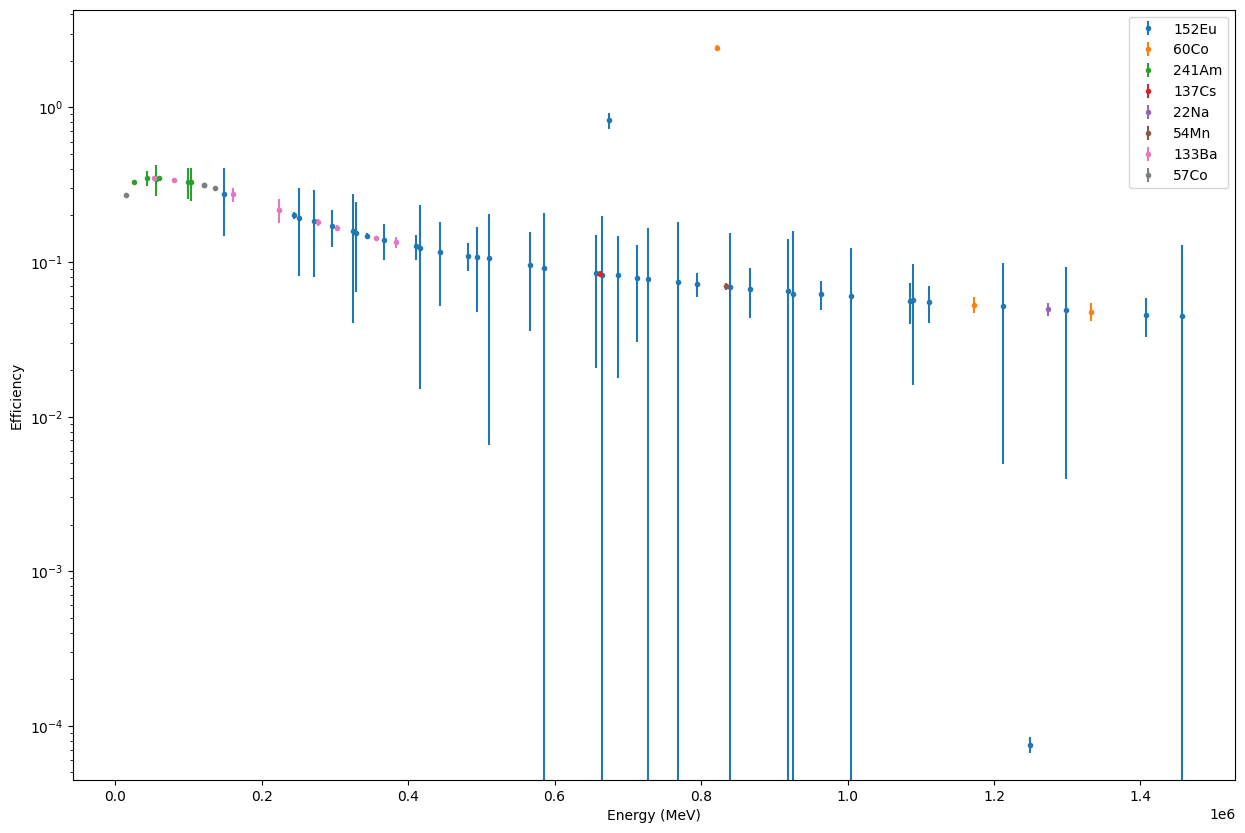

In [14]:
fig = plt.figure(figsize = [15,10])

closest_index_1 = (np.abs(np.array(peak_locations_array[0]) - 1249938)).argmin()

# Replace the efficiency value at this index with the improved efficiency
efficiencies_array[0][closest_index_1] = eu152_improved_efficiency_1
errors[0][closest_index_1] = eu152_improved_efficiency_1_error

for i in range(len(labels)):
    plt.errorbar(peak_locations_array[i], efficiencies_array[i], yerr = errors[i], fmt = '.', label = labels[i])

#print(peak_locations_array[0])

plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Efficiency')
plt.legend()
plt.show()

## Comparing simulated data to real data

1271153.0
615021.0
228078.0
274722.0
293926.0
53900.0
692961.0
145097.0


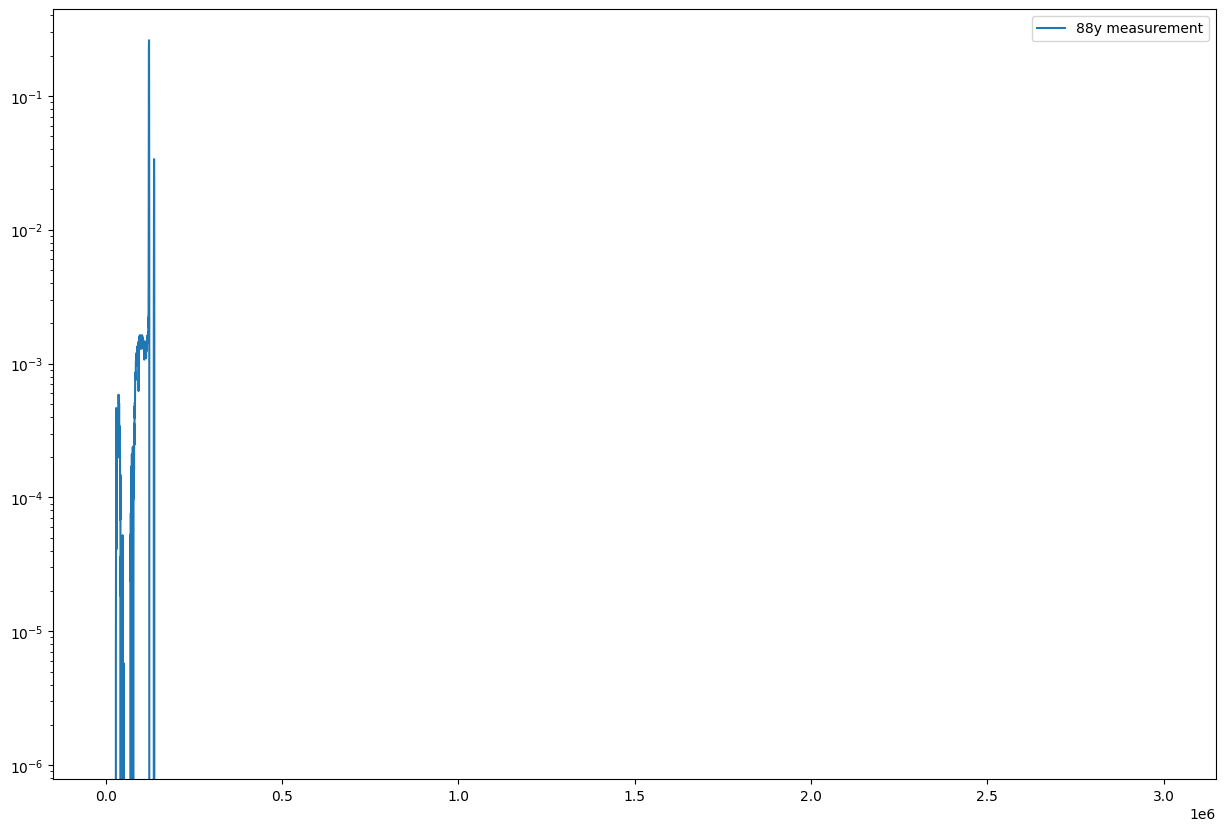

In [15]:
plt.figure(figsize = [15, 10])

background_measurement = np.genfromtxt('detector_1_background.csv', delimiter = ',', skip_header = False)
background = np.array(background_measurement)
calibrated_background = openmc_tools.spectrum_calibration(background)

detector_channels = np.arange(0, len(background), 1)
calibrated_channels = openmc_tools.detector_channel_calibration(detector_channels, 0.3659515, 0.3604087)

co60_measurement = np.array(np.genfromtxt('60co_detector_1.csv', delimiter = ',', skip_header = False))
calibrated_co60_measurement = openmc_tools.spectrum_calibration(co60_measurement)
background_removed_co60_measurement = calibrated_co60_measurement - calibrated_background

am241_measurement = np.array(np.genfromtxt('241am_detector_1.csv', delimiter = ',', skip_header = False))
calibrated_am241_measurement = openmc_tools.spectrum_calibration(am241_measurement)
background_removed_am241_measurement = calibrated_am241_measurement - calibrated_background

cs137_measurement = np.array(np.genfromtxt('137cs_detector_1.csv', delimiter = ',', skip_header = False))
calibrated_cs137_measurement = openmc_tools.spectrum_calibration(cs137_measurement)
background_removed_cs137_measurement = calibrated_cs137_measurement - calibrated_background

na22_measurement = np.array(np.genfromtxt('22na_detector_1.csv', delimiter = ',', skip_header = False))
calibrated_na22_measurement = openmc_tools.spectrum_calibration(na22_measurement)
background_removed_na22_measurement = calibrated_na22_measurement - calibrated_background

mn54_measurement = np.array(np.genfromtxt('54mn_detector_1.csv', delimiter = ',', skip_header = False))
calibrated_mn54_measurement = openmc_tools.spectrum_calibration(mn54_measurement)
background_removed_mn54_measurement = calibrated_mn54_measurement - calibrated_background

ba133_measurement = np.array(np.genfromtxt('133ba_detector_1.csv', delimiter = ',', skip_header = False))
calibrated_ba133_measurement = openmc_tools.spectrum_calibration(ba133_measurement)
background_removed_ba133_measurement = calibrated_ba133_measurement - calibrated_background

co57_measurement = np.array(np.genfromtxt('57co_detector_1.csv', delimiter = ',', skip_header = False))
calibrated_co57_measurement = openmc_tools.spectrum_calibration(co57_measurement)
background_removed_co57_measurement = calibrated_co57_measurement - calibrated_background

plt.plot(calibrated_channels, background_removed_co57_measurement, label = '88y measurement')

plt.yscale('log')
plt.ylim(bottom = 1 / np.sum(background))
plt.legend()
plt.show()


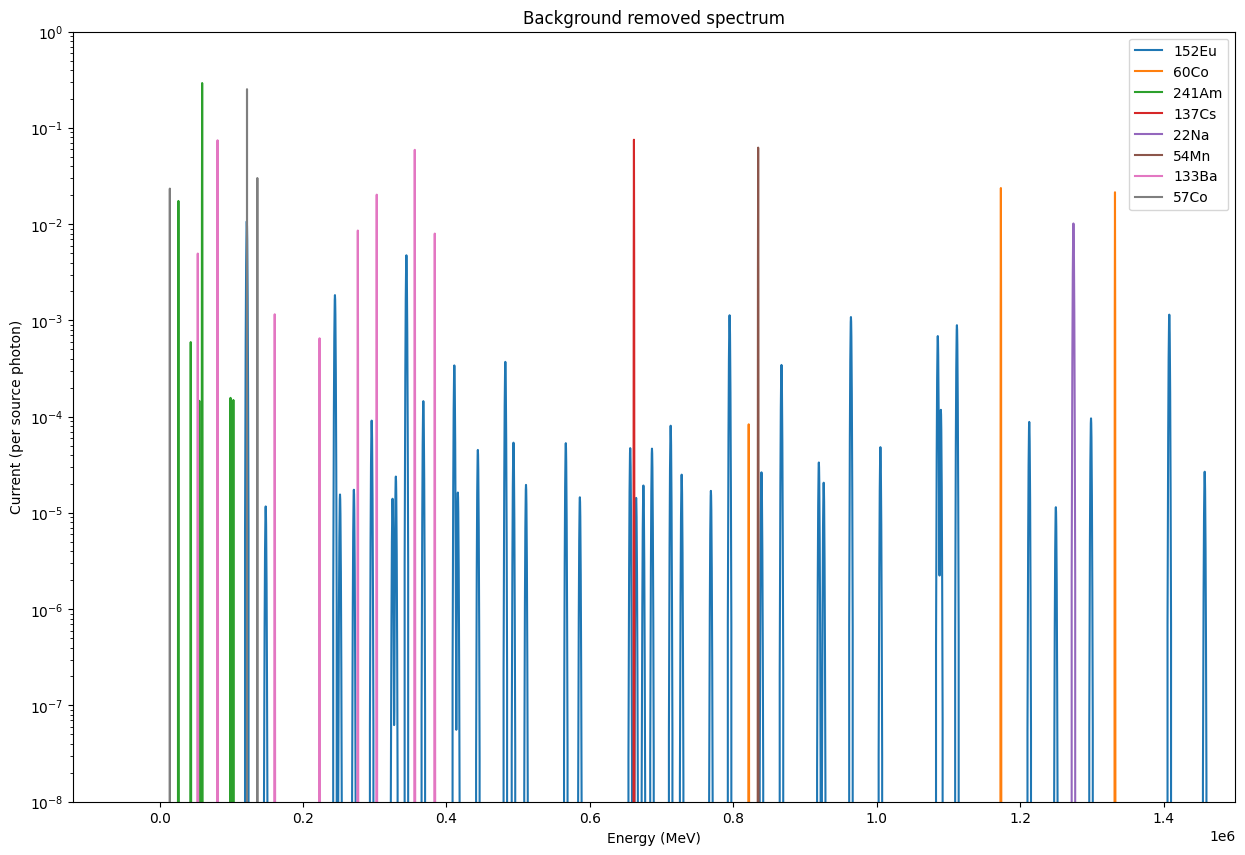

CPU times: user 877 ms, sys: 29.8 ms, total: 907 ms
Wall time: 905 ms


In [16]:
%%time
plt.figure(figsize = [15, 10])

eu152_fwhm = 1500
co60_fwhm = 300
am241_fwhm = 300
cs137_fwhm = 300
na22_fwhm = 1400
mn54_fwhm = 300
ba133_fwhm = 300
co57_fwhm = 10

broadened_eu152_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], eu152_background_removed_spectrum, eu152_fwhm)
broadened_co60_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], co60_background_removed_spectrum, co60_fwhm)
broadened_am241_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], am241_background_removed_spectrum, am241_fwhm)
broadened_cs137_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], cs137_background_removed_spectrum, cs137_fwhm)
broadened_na22_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], na22_background_removed_spectrum, na22_fwhm)
broadened_mn54_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], mn54_background_removed_spectrum, mn54_fwhm)
broadened_ba133_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], ba133_background_removed_spectrum, ba133_fwhm)
broadened_co57_spectrum = openmc_tools.apply_gaussian_broadening(energy_bins[:-1], co57_background_removed_spectrum, co57_fwhm)

broadened_spectra_array = [broadened_eu152_spectrum, broadened_co60_spectrum, broadened_am241_spectrum, broadened_cs137_spectrum,
                           broadened_na22_spectrum, broadened_mn54_spectrum, broadened_ba133_spectrum, broadened_co57_spectrum]

for i in range(len(labels)):
    plt.plot(energy_bins[:-1], broadened_spectra_array[i], label = labels[i])

plt.yscale('log')
plt.ylim((1E-8, 1))
plt.xlim(right = 1.5E6)
plt.xlabel('Energy (MeV)')
plt.ylabel('Current (per source photon)')
plt.title('Background removed spectrum')
plt.legend()
plt.show()

1271153.0
615021.0
ratios of measured/simulated peaks for 60Co:
821475.38 eV: 2.68899
1173134.17 eV: 0.82955
1332254.41 eV: 0.78181
228078.0
ratios of measured/simulated peaks for 241Am:
59292.52 eV: 0.96766
274722.0
ratios of measured/simulated peaks for 137Cs:
661435.38 eV: 1.00879
293926.0
ratios of measured/simulated peaks for 22Na:
1274308.89 eV: 1.05271
53900.0
ratios of measured/simulated peaks for 54Mn:
834658.76 eV: 0.94425
692961.0
ratios of measured/simulated peaks for 133Ba:
53160.72 eV: 0.50456
80753.82 eV: 0.91311
160467.24 eV: 1.42098
223011.61 eV: 0.90705
276358.27 eV: 0.89806
302725.02 eV: 0.99983
355765.10 eV: 0.99910
383664.79 eV: 0.98055
145097.0
ratios of measured/simulated peaks for 57Co:
121836.89 eV: 1.02870
136246.62 eV: 1.11543


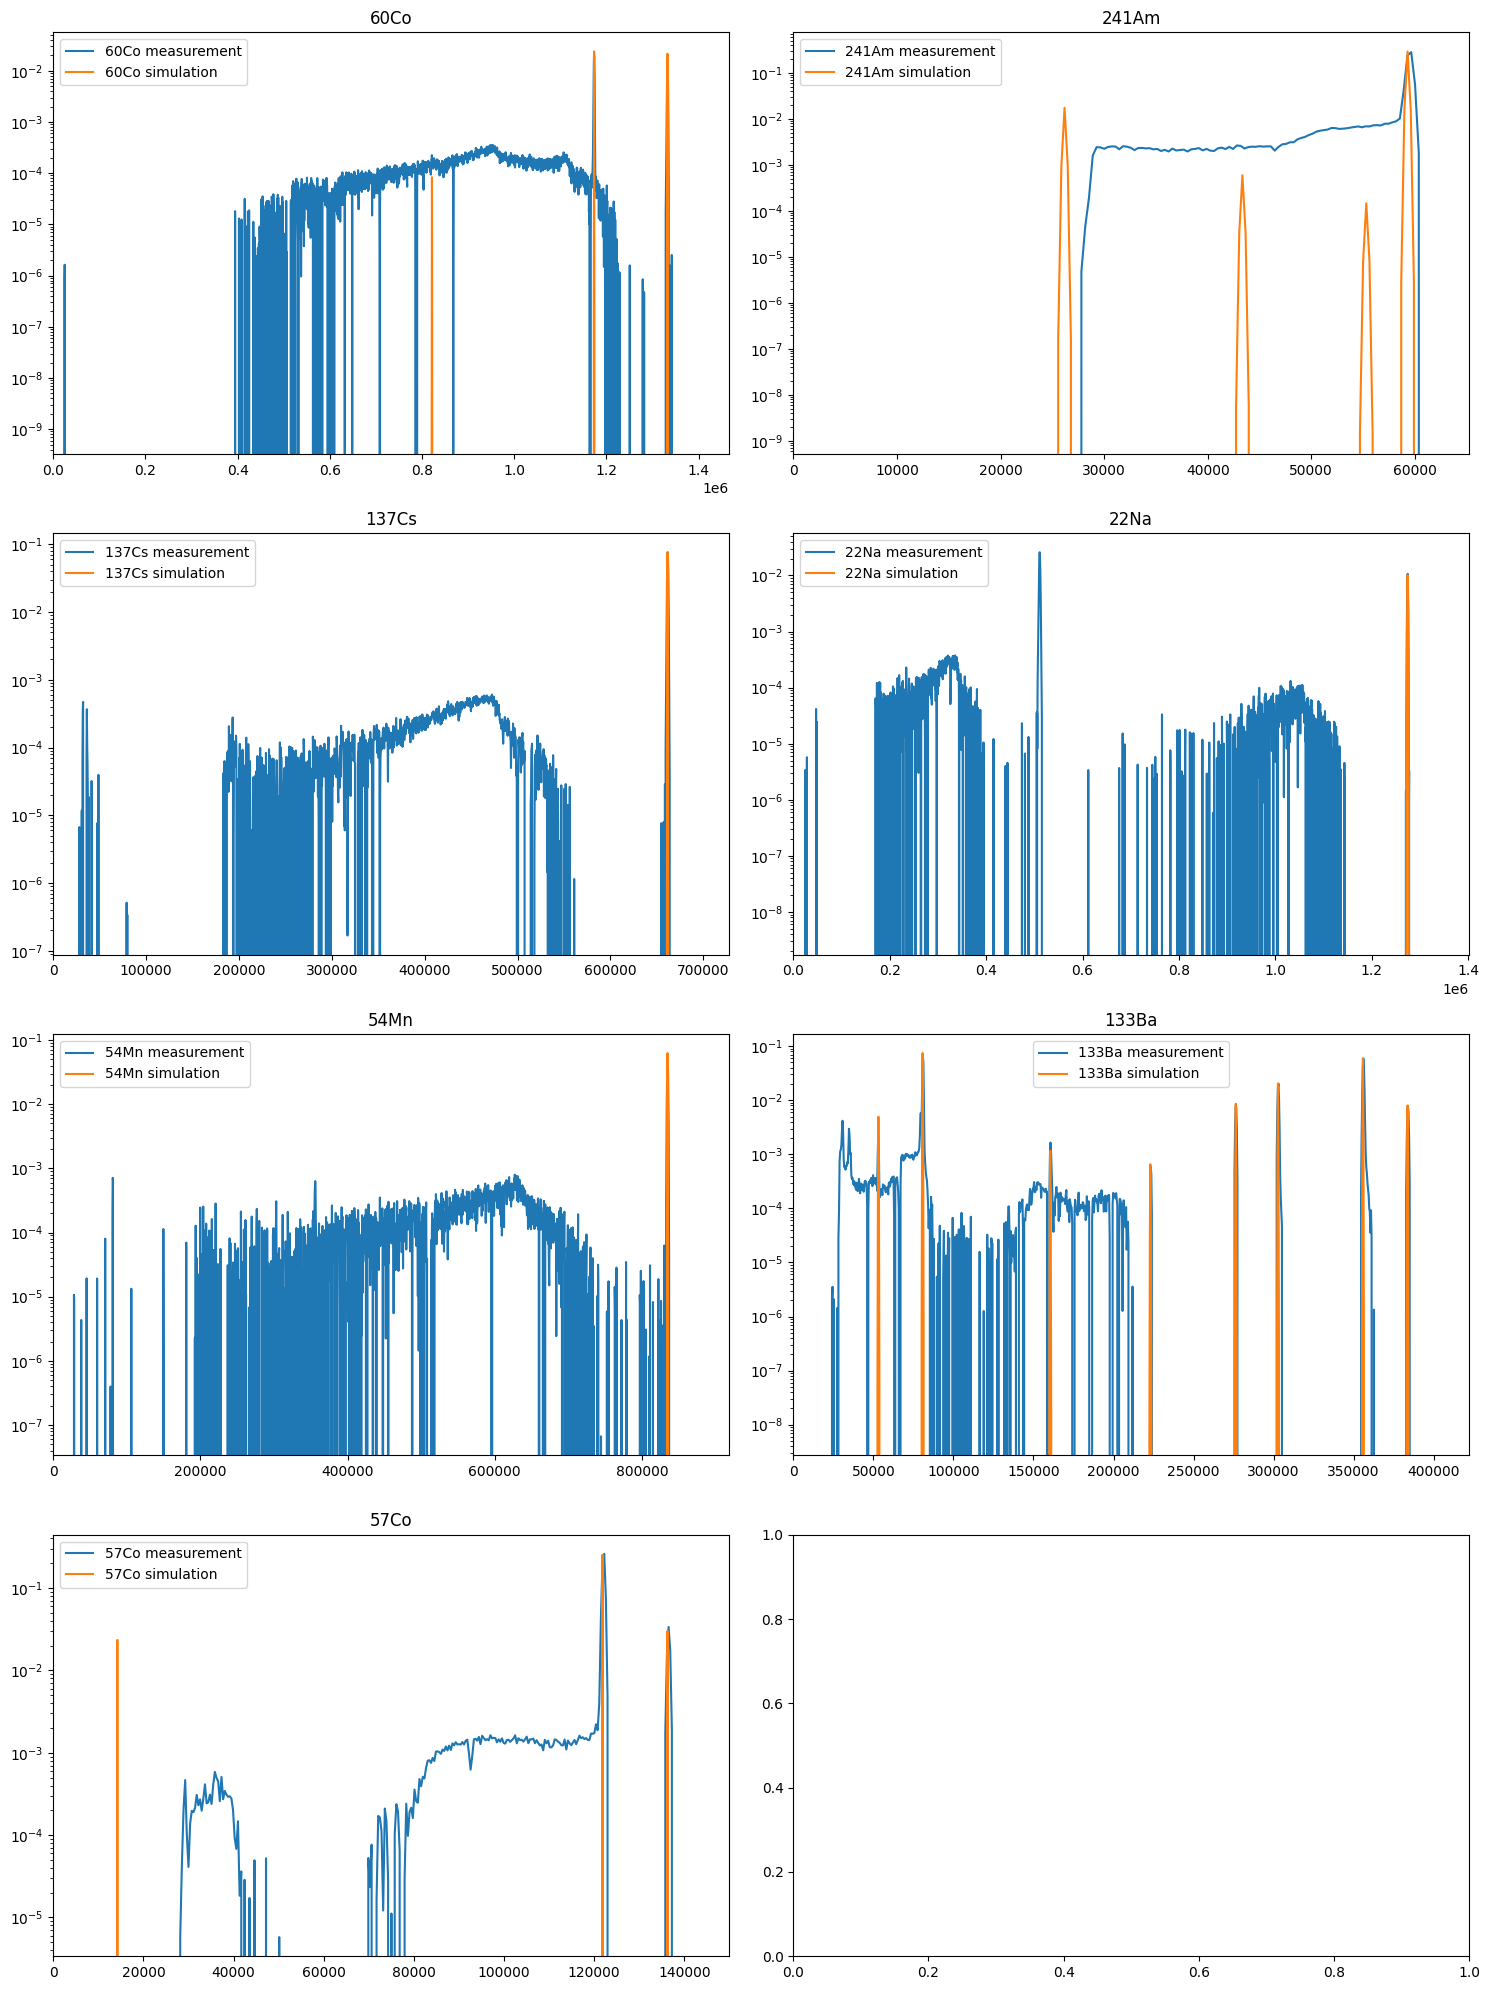

In [17]:
background_measurement = np.genfromtxt('detector_1_background.csv', delimiter = ',', skip_header = False)
background = np.array(background_measurement)
calibrated_background = openmc_tools.spectrum_calibration(background)

detector_channels = np.arange(0, len(background), 1)
calibrated_channels = openmc_tools.detector_channel_calibration(detector_channels, 0.3659515, 0.3604087)

measurements = [
    ('60co_detector_1.csv', '60Co'),
    ('241am_detector_1.csv', '241Am'),
    ('137cs_detector_1.csv', '137Cs'),
    ('22na_detector_1.csv', '22Na'),
    ('54mn_detector_1.csv', '54Mn'),
    ('133ba_detector_1.csv', '133Ba'),
    ('57co_detector_1.csv', '57Co'),
]

background_removed_spectra = {
    '60co': co60_background_removed_spectrum,
    '241am': am241_background_removed_spectrum,
    '137cs': cs137_background_removed_spectrum,
    '22na': na22_background_removed_spectrum,
    '54mn': mn54_background_removed_spectrum,
    '133ba': ba133_background_removed_spectrum,
    '57co': co57_background_removed_spectrum,
}

broadened_spectra = {
    '60co': broadened_co60_spectrum,
    '241am': broadened_am241_spectrum,
    '137cs': broadened_cs137_spectrum,
    '22na': broadened_na22_spectrum,
    '54mn': broadened_mn54_spectrum,
    '133ba': broadened_ba133_spectrum,
    '57co': broadened_co57_spectrum,
}

fig, ax = plt.subplots(4, 2, figsize=[15, 20])

for i, (filename, label) in enumerate(measurements):
    measurement = np.array(np.genfromtxt(filename, delimiter=',', skip_header=False))
    calibrated_measurement = openmc_tools.spectrum_calibration(measurement)
    background_removed_measurement = calibrated_measurement - calibrated_background
    
    ax[i // 2, i % 2].plot(calibrated_channels, background_removed_measurement, label=f'{label} measurement')
    
    sim_spectrum = broadened_spectra[label.lower()]
    ax[i // 2, i % 2].plot(energy_bins[:-1], sim_spectrum, label=f'{label} simulation')

    ax[i // 2, i % 2].set_yscale('log')
    ax[i // 2, i % 2].legend()
    ax[i // 2, i % 2].set_title(label)

    energies, ratios = openmc_tools.peak_height_ratios(energy_bins[:-1], sim_spectrum, background_removed_measurement, calibrated_channels)
    ax[i // 2, i % 2].set_xlim((0, (max(energies) + 0.1 * max(energies))))

    print(f"ratios of measured/simulated peaks for {label}:")
    for i in range(len(energies)):
        print(f"{energies[i]:.2f} eV: {ratios[i]:.5f}") 

plt.tight_layout()
plt.show()